In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "fairness-variance":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /Users/falaaharifkhan/Documents/fairness-variance


## Import dependencies

In [4]:
import altair as alt
from altair import datum

import pandas as pd
import seaborn as sns
from IPython.display import display

from configs import config
from source.data_viz_utils import create_average_metrics_df, visualize_fairness_metrics_for_prediction_metric
from source.custom_classes.metrics_composer import MetricsComposer

sns.set_theme(style="whitegrid")

## Create average metrics files

In [5]:
STATE = config.DATASET_CONFIG['state']
YEAR = config.DATASET_CONFIG['year']
DATASET_NAME = f"Folktables_{STATE}_{YEAR}"

MODELS_NAMES = [model_config['model_name'] for model_config in config.MODELS_CONFIG]

In [6]:
models_average_results_dct = create_average_metrics_df(DATASET_NAME, MODELS_NAMES,
                                                       results_path=os.path.join('results', 'hypothesis_space',
                                                                                 'folktables_GA_2018_metrics'))

File with average metrics for LogisticRegression is created
File with average metrics for DecisionTreeClassifier is created
File with average metrics for RandomForestClassifier is created
File with average metrics for XGBClassifier is created
File with average metrics for KNeighborsClassifier is created
File with average metrics for MLPClassifier is created


## Visualize average metrics

In [7]:
SENSITIVE_ATTRIBUTES = ['SEX', 'RAC1P', 'SEX_RAC1P']

metrics_composer = MetricsComposer(SENSITIVE_ATTRIBUTES, models_average_results_dct['DecisionTreeClassifier'])
metrics_composer.compose_metrics()

,SEX,RAC1P,SEX_RAC1P
Equalized_Odds_TPR,-0.026957,0.029055,0.003553
Equalized_Odds_FPR,0.091946,-0.001902,0.088360
Disparate_Impact,1.140465,1.065675,1.174613
Statistical_Parity_Difference,0.148011,0.072391,0.177042
Accuracy_Parity,-0.066899,0.010552,-0.050567
Label_Stability_Ratio,0.969949,0.992203,0.958893
IQR_Parity,0.003000,0.003400,0.007200
Std_Parity,0.000700,0.004200,0.005700
Std_Ratio,1.012915,1.078947,1.106145
Jitter_Parity,0.017100,0.004700,0.023800


### Overall metrics visualizations

In [8]:
def visualize_overall_metrics(models_average_results_dct, metrics_names, reversed_metrics_names=[], x_label="Prediction Metrics"):
    metrics_names = set(metrics_names + reversed_metrics_names)

    overall_metrics_df = pd.DataFrame()
    for model_name in models_average_results_dct.keys():
        model_average_results_df = models_average_results_dct[model_name].reset_index().copy(deep=True)
        model_average_results_df = model_average_results_df.loc[model_average_results_df['index'].isin(metrics_names)]
        overall_model_metrics_df = pd.DataFrame()
        overall_model_metrics_df['overall'] = model_average_results_df['overall']
        overall_model_metrics_df['metric'] = model_average_results_df['index']
        overall_model_metrics_df['model_name'] = model_name
        overall_metrics_df = pd.concat([overall_metrics_df, overall_model_metrics_df])

    overall_metrics_df.loc[overall_metrics_df['metric'].isin(reversed_metrics_names), 'overall'] = \
        1 - overall_metrics_df.loc[overall_metrics_df['metric'].isin(reversed_metrics_names), 'overall']

    # Draw a nested barplot
    height = 9 if len(metrics_names) >= 7 else 6
    g = sns.catplot(
        data=overall_metrics_df, kind="bar",
        x="overall", y="metric", hue="model_name",
        #errorbar="sd",
        palette="bright",
        alpha=.8, height=height
    )
    g.despine(left=True)
    g.set_axis_labels("", x_label)
    g.legend.set_title("")


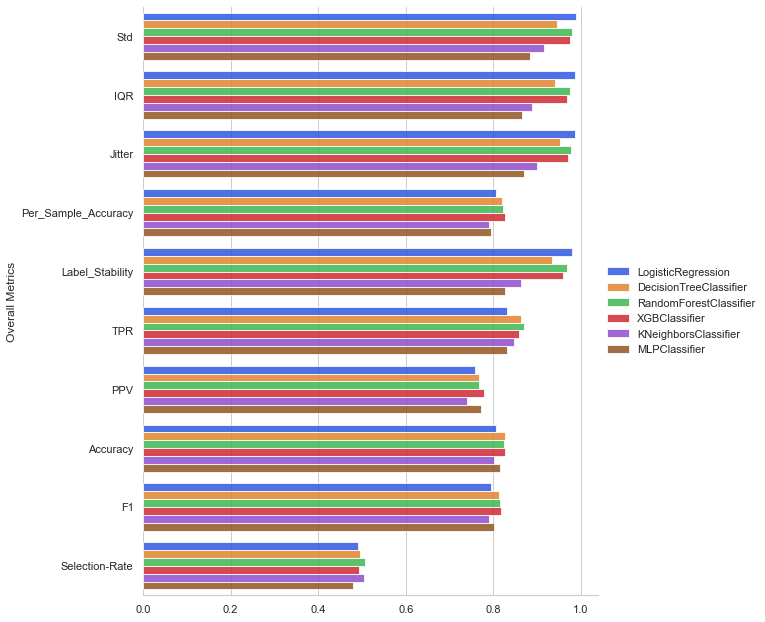

In [9]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate',
                                         'Per_Sample_Accuracy', 'Label_Stability'],
                          reversed_metrics_names=['Std', 'IQR', 'Jitter'],
                          x_label="Overall Metrics")

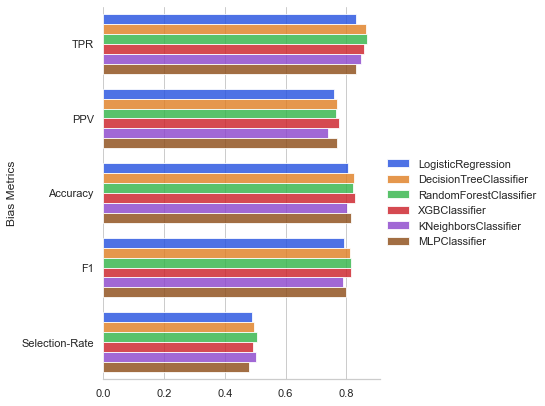

In [10]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate'],
                          x_label="Bias Metrics")

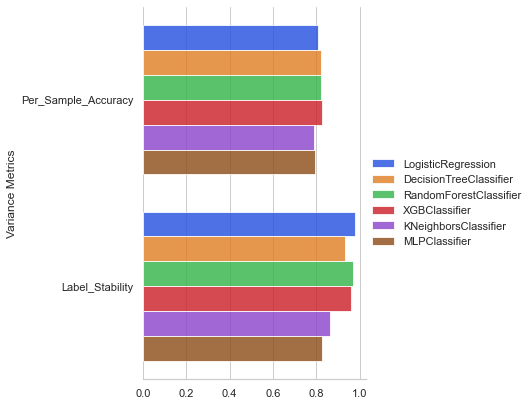

In [11]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['Per_Sample_Accuracy', 'Label_Stability'],
                          x_label="Variance Metrics")

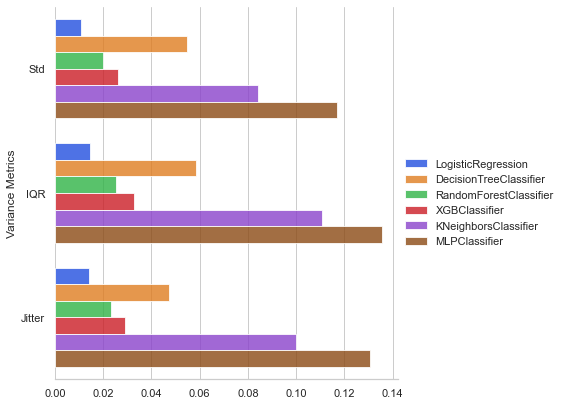

In [12]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['Std', 'IQR', 'Jitter'],
                          x_label="Variance Metrics")

In [13]:
models_average_results_df = pd.DataFrame()

for model_name in models_average_results_dct.keys():
    model_results_df = models_average_results_dct[model_name].reset_index()
    model_results_df['Model_Name'] = model_name
    model_results_df = model_results_df.rename(columns={"index": "Metric"})
    
    models_average_results_df = pd.concat([models_average_results_df, model_results_df])

models_average_results_df.head(30)

,Metric,overall,SEX_RAC1P_priv,SEX_RAC1P_dis,SEX_priv,SEX_dis,RAC1P_priv,RAC1P_dis,Model_Name
0,General_Ensemble_Accuracy,0.806900,0.834800,0.784300,0.834900,0.779800,0.806100,0.808300,LogisticRegression
1,Mean,0.552900,0.496200,0.593100,0.519600,0.585000,0.538300,0.580600,LogisticRegression
2,Std,0.010800,0.010300,0.012300,0.010700,0.010900,0.010200,0.011900,LogisticRegression
3,IQR,0.014400,0.013800,0.016400,0.014300,0.014500,0.013600,0.015900,LogisticRegression
4,Entropy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,LogisticRegression
5,Jitter,0.014200,0.013000,0.014400,0.013600,0.014700,0.014000,0.014600,LogisticRegression
6,Per_Sample_Accuracy,0.806100,0.834000,0.783600,0.834200,0.779000,0.805200,0.807700,LogisticRegression
7,Label_Stability,0.980100,0.981800,0.980000,0.980900,0.979300,0.980300,0.979600,LogisticRegression
8,TPR,0.831983,0.886848,0.778497,0.883288,0.773995,0.835698,0.824347,LogisticRegression
9,TNR,0.786559,0.780390,0.788480,0.789648,0.783940,0.780992,0.796504,LogisticRegression


In [53]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 23}

plt.rc('font', **font)

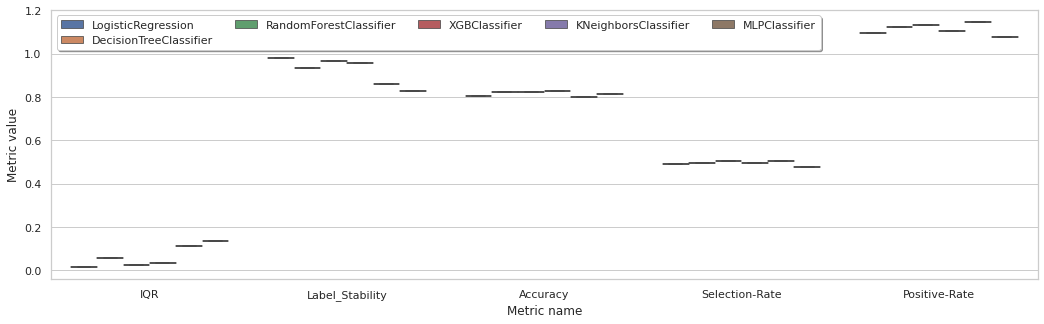

In [62]:
#to_plot = models_average_results_df[models_average_results_df['Metric'].isin(['Std', 'IQR', 'Entropy', 'Jitter', 'FNR','FPR'])]
to_plot = models_average_results_df[models_average_results_df['Metric'].isin(['Label_Stability', 'IQR', 'SD', 'Accuracy', 'Selection-Rate', 'Positive-Rate'])]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))


sns.boxplot(
            x = to_plot['Metric'],
            y = to_plot['overall'],
            hue= to_plot['Model_Name'],
            #order=['Accuracy']
            #order=['Accuracy','TNR','TPR','FNR','FPR','Selection-Rate']
            )

plt.legend(loc='upper left',
          ncol=5, fancybox=True, shadow=True)
plt.xlabel("Metric name")
plt.ylabel("Metric value")
#plt.ylim(0,1)
#plt.title("Peformance on overall test set: "+experiment)

plt.tight_layout()

#plt.savefig(filename+'_overall.png', bbox_inches='tight')

In [15]:
df_for_models_bias_metrics_chart = models_average_results_df.melt(id_vars=["Metric", "Model_Name", "overall"],
                                                                  var_name="Subgroup",
                                                                  value_name="Value")
df_for_models_bias_metrics_chart[df_for_models_bias_metrics_chart["Model_Name"] == "LogisticRegression"]

,Metric,Model_Name,overall,Subgroup,Value
0,General_Ensemble_Accuracy,LogisticRegression,0.806900,SEX_RAC1P_priv,0.834800
1,Mean,LogisticRegression,0.552900,SEX_RAC1P_priv,0.496200
2,Std,LogisticRegression,0.010800,SEX_RAC1P_priv,0.010300
3,IQR,LogisticRegression,0.014400,SEX_RAC1P_priv,0.013800
4,Entropy,LogisticRegression,0.000000,SEX_RAC1P_priv,0.000000
...,...,...,...,...,...
522,FPR,LogisticRegression,0.213441,RAC1P_dis,0.203496
523,Accuracy,LogisticRegression,0.806851,RAC1P_dis,0.808312
524,F1,LogisticRegression,0.793753,RAC1P_dis,0.784826
525,Selection-Rate,LogisticRegression,0.489763,RAC1P_dis,0.466782


In [69]:
models_composed_metrics_df = pd.DataFrame()
for model_name in models_average_results_dct.keys():
    metrics_composer = MetricsComposer(SENSITIVE_ATTRIBUTES, models_average_results_dct[model_name])
    model_composed_metrics_df = metrics_composer.compose_metrics().reset_index()
    model_composed_metrics_df['Model_Name'] = model_name
    model_composed_metrics_df = model_composed_metrics_df.rename(columns={"index": "Metric"})
    
    models_composed_metrics_df = pd.concat([models_composed_metrics_df, model_composed_metrics_df])

models_composed_metrics_df

,Metric,SEX,RAC1P,SEX_RAC1P,Model_Name
0,Equalized_Odds_TPR,-0.109293,-0.011351,-0.108351,LogisticRegression
1,Equalized_Odds_FPR,0.005708,-0.015512,-0.008090,LogisticRegression
2,Disparate_Impact,0.976502,1.005958,0.974021,LogisticRegression
3,Statistical_Parity_Difference,-0.026049,0.006519,-0.028504,LogisticRegression
4,Accuracy_Parity,-0.055021,0.002229,-0.050500,LogisticRegression
5,Label_Stability_Ratio,0.998369,0.999286,0.998167,LogisticRegression
6,IQR_Parity,0.000200,0.002300,0.002600,LogisticRegression
7,Std_Parity,0.000200,0.001700,0.002000,LogisticRegression
8,Std_Ratio,1.018692,1.166667,1.194175,LogisticRegression
9,Jitter_Parity,0.001100,0.000600,0.001400,LogisticRegression


In [17]:
df_for_model_metrics_chart = models_composed_metrics_df.melt(id_vars=["Metric", "Model_Name"],
                                                                   var_name="Subgroup",
                                                                   value_name="Value")
df_for_model_metrics_chart[df_for_model_metrics_chart["Model_Name"] == "LogisticRegression"]

,Metric,Model_Name,Subgroup,Value
0,Equalized_Odds_TPR,LogisticRegression,SEX,-0.109293
1,Equalized_Odds_FPR,LogisticRegression,SEX,0.005708
2,Disparate_Impact,LogisticRegression,SEX,0.976502
3,Statistical_Parity_Difference,LogisticRegression,SEX,-0.026049
4,Accuracy_Parity,LogisticRegression,SEX,-0.055021
5,Label_Stability_Ratio,LogisticRegression,SEX,0.998369
6,IQR_Parity,LogisticRegression,SEX,0.000200
7,Std_Parity,LogisticRegression,SEX,0.000200
8,Std_Ratio,LogisticRegression,SEX,1.018692
9,Jitter_Parity,LogisticRegression,SEX,0.001100


In [18]:
def create_models_metrics_bar_chart(df, metrics_lst, default_plot_metric, metrics_group_name):
    df_for_model_metrics_chart = df.loc[df['Metric'].isin(metrics_lst)]
    
    radio_select = alt.selection_single(fields=['Metric'], init={'Metric': default_plot_metric}, empty="none")
    color_condition = alt.condition(radio_select,
                          alt.Color('Metric:N', legend=None, scale=alt.Scale(scheme="tableau20")),
                          alt.value('lightgray'))


    models_metrics_chart = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_bar()
            .transform_filter(radio_select)
            .encode(
                x='Value:Q',
                y=alt.Y('Model_Name:N', axis=None),
                color=alt.Color(
                    'Model_Name:N',
                    scale=alt.Scale(scheme="tableau20")
                ),
                row='Subgroup:N',
            )
    )


    select_metric_legend = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_circle(size=200)
            .encode(
                y=alt.Y("Metric:N", axis=alt.Axis(title=f"Select {metrics_group_name} Metric", titleFontSize=15)),
                color=color_condition,
            )
            .add_selection(radio_select)
    )


    color_legend = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_circle(size=200)
            .encode(
                y=alt.Y("Model_Name:N", axis=alt.Axis(title="Model Name", titleFontSize=15)),
                color=alt.Color("Model_Name:N", scale=alt.Scale(scheme="tableau20")),
            )
    )
    
    return models_metrics_chart, select_metric_legend, color_legend

In [19]:
bias_metrics_lst = [
    'Accuracy_Parity',
    'Equalized_Odds_TPR',
    'Equalized_Odds_FPR',
    'Disparate_Impact',
    'Statistical_Parity_Difference',
]
models_bias_metrics_chart, select_bias_metric_legend, bias_color_legend = \
                create_models_metrics_bar_chart(df_for_model_metrics_chart, bias_metrics_lst, 
                                                default_plot_metric=bias_metrics_lst[0],
                                                metrics_group_name="Bias")

In [20]:
variance_metrics_lst = [
    'IQR_Parity',
    'Label_Stability_Ratio',
    'Std_Parity',
    'Std_Ratio',
    'Jitter_Parity',
]
models_variance_metrics_chart, select_variance_metric_legend, variance_color_legend = \
                create_models_metrics_bar_chart(df_for_model_metrics_chart, variance_metrics_lst,
                                                default_plot_metric=variance_metrics_lst[0],
                                                metrics_group_name="Variance")

In [21]:
(
    alt.hconcat(
        alt.vconcat(
            select_bias_metric_legend.properties(height=200, width=50),
            select_variance_metric_legend.properties(height=200, width=50),
            bias_color_legend.properties(height=200, width=50),
        ),
        models_bias_metrics_chart.properties(height=200, width=300, title="Bias Metric Plot"),
        models_variance_metrics_chart.properties(height=200, width=300, title="Variance Metric Plot"),
    )
)

alt.HConcatChart(...)

In [44]:
def color_df(val):
    if val is 'RandomForestClassifier':
        color = 'pink' 
    if val is 'LogisticRegression':
        color = 'yellow'
    if val is 'DecisionTreeClassifier':
        color = 'cyan'
    if val is 'XGBClassifier':
        color = 'green'
    if val is 'KNeighborsClassifier':
        color = 'orange'
    if val is 'MLPClassifier':
        color = 'purple'
    return 'background-color: %s' % color

In [45]:
sorted_res = df_for_model_metrics_chart.sort_values(by=['Value'])
sorted_res

,Metric,Model_Name,Subgroup,Value
0,Equalized_Odds_TPR,LogisticRegression,SEX,-0.109293
120,Equalized_Odds_TPR,LogisticRegression,SEX_RAC1P,-0.108351
50,Equalized_Odds_TPR,MLPClassifier,SEX,-0.080833
170,Equalized_Odds_TPR,MLPClassifier,SEX_RAC1P,-0.079353
14,Accuracy_Parity,DecisionTreeClassifier,SEX,-0.066899
...,...,...,...,...
142,Disparate_Impact,RandomForestClassifier,SEX_RAC1P,1.191909
128,Std_Ratio,LogisticRegression,SEX_RAC1P,1.194175
118,Std_Ratio,MLPClassifier,RAC1P,1.202006
158,Std_Ratio,XGBClassifier,SEX_RAC1P,1.319149


In [47]:
results = {}

for metric in ['Disparate_Impact','Label_Stability_Ratio']:
    for subgroup in ['SEX','RAC1P','SEX_RAC1P']:
        key_name = metric+'_'+subgroup
        results[key_name] = sorted_res[(sorted_res.Metric == metric) & (sorted_res.Subgroup == subgroup)]['Model_Name'].values
        
pd.DataFrame(results).T.style.applymap(color_df)

,0,1,2,3,4,5
Disparate_Impact_SEX,LogisticRegression,MLPClassifier,KNeighborsClassifier,XGBClassifier,DecisionTreeClassifier,RandomForestClassifier
Disparate_Impact_RAC1P,MLPClassifier,LogisticRegression,XGBClassifier,RandomForestClassifier,DecisionTreeClassifier,KNeighborsClassifier
Disparate_Impact_SEX_RAC1P,LogisticRegression,MLPClassifier,XGBClassifier,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier
Label_Stability_Ratio_SEX,MLPClassifier,KNeighborsClassifier,DecisionTreeClassifier,XGBClassifier,RandomForestClassifier,LogisticRegression
Label_Stability_Ratio_RAC1P,MLPClassifier,XGBClassifier,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,LogisticRegression
Label_Stability_Ratio_SEX_RAC1P,MLPClassifier,KNeighborsClassifier,DecisionTreeClassifier,XGBClassifier,RandomForestClassifier,LogisticRegression


In [48]:
results = {}

for metric in ['Accuracy_Parity','Equalized_Odds_FPR','Statistical_Parity_Difference','IQR_Parity','Jitter_Parity','Std_Parity']:
    for subgroup in ['SEX','RAC1P','SEX_RAC1P']:
        key_name = metric+'_'+subgroup
        results[key_name] = sorted_res[(sorted_res.Metric == metric) & (sorted_res.Subgroup == subgroup)]['Model_Name'].values
        
pd.DataFrame(results).T.style.applymap(color_df)

,0,1,2,3,4,5
Accuracy_Parity_SEX,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,MLPClassifier,XGBClassifier,LogisticRegression
Accuracy_Parity_RAC1P,MLPClassifier,LogisticRegression,KNeighborsClassifier,XGBClassifier,DecisionTreeClassifier,RandomForestClassifier
Accuracy_Parity_SEX_RAC1P,MLPClassifier,KNeighborsClassifier,DecisionTreeClassifier,LogisticRegression,RandomForestClassifier,XGBClassifier
Equalized_Odds_FPR_SEX,LogisticRegression,MLPClassifier,XGBClassifier,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier
Equalized_Odds_FPR_RAC1P,XGBClassifier,LogisticRegression,MLPClassifier,RandomForestClassifier,DecisionTreeClassifier,KNeighborsClassifier
Equalized_Odds_FPR_SEX_RAC1P,LogisticRegression,MLPClassifier,XGBClassifier,KNeighborsClassifier,RandomForestClassifier,DecisionTreeClassifier
Statistical_Parity_Difference_SEX,LogisticRegression,MLPClassifier,KNeighborsClassifier,XGBClassifier,DecisionTreeClassifier,RandomForestClassifier
Statistical_Parity_Difference_RAC1P,MLPClassifier,LogisticRegression,XGBClassifier,RandomForestClassifier,DecisionTreeClassifier,KNeighborsClassifier
Statistical_Parity_Difference_SEX_RAC1P,LogisticRegression,MLPClassifier,XGBClassifier,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier
IQR_Parity_SEX,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,XGBClassifier,KNeighborsClassifier,MLPClassifier


In [64]:
ls

README.md           data/               requirements.txt
Sample_Usage.ipynb  docs/               results/
configs/            notebooks/          utils/


In [67]:
df = pd.read_csv("results/hypothesis_space/compas_without_sensitive_attrs_metrics/Average_Metrics_COMPAS_Without_Sensitive_Attributes_DecisionTreeClassifier.csv")

In [68]:
df

,index,overall,sex_race_priv,sex_race_dis,sex_priv,sex_dis,race_priv,race_dis
0,General_Ensemble_Accuracy,0.695076,0.688822,0.686957,0.691211,0.710280,0.700000,0.691693
1,Mean,0.537914,0.597559,0.535291,0.527466,0.579026,0.604989,0.491841
2,Std,0.083093,0.078371,0.081106,0.083846,0.080129,0.078514,0.086238
3,IQR,0.105571,0.100866,0.102885,0.106945,0.100164,0.099977,0.109414
4,Entropy,0.203968,0.183521,0.229767,0.000000,0.203723,0.181207,0.000000
5,Jitter,0.120510,0.108013,0.138567,0.120072,0.122236,0.106920,0.129846
6,Per_Sample_Accuracy,0.670109,0.668369,0.666261,0.665558,0.688014,0.678709,0.664201
7,Label_Stability,0.844555,0.861692,0.816000,0.846983,0.835000,0.860628,0.833514
8,TPR,0.629259,0.473684,0.620000,0.647343,0.541176,0.464286,0.712991
9,TNR,0.754039,0.833333,0.738462,0.733645,0.821705,0.851145,0.667797
